In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path
from dateutil.relativedelta import relativedelta
import tensorflow as tf

from matplotlib import pyplot as plt

2023-09-07 20:27:43.925743: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 20:27:43.975498: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-07 20:27:43.976306: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 20:27:44.766323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
zarr_ds = xr.open_zarr(store='/home/jovyan/shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)
zarr_new = zarr_ds.sel(
    lat=slice(35, -5),
    lon=slice(45, 90),
    time=slice('2000-01-01', '2020-12-31')
)
zarr_new

<xarray.Dataset>
Dimensions:          (time: 7671, lat: 149, lon: 181)
Coordinates:
  * lat              (lat) float32 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon              (lon) float32 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time             (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
Data variables: (12/19)
    CHL              (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    adt              (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    curr_dir         (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    curr_speed       (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    ...               ...
    ug_curr          (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    v_curr           (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    vg_curr          (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    wind_dir         (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
    wind_speed       (time, lat, lon) float32 dask.array<chunksize=(30, 149, 181), meta=np.ndarray>
Attributes: (12/17)
    creator_email:              minhphan@uw.edu
    creator_name:               Minh Phan
    creator_type:               person
    date_created:               2023-07-19
    geospatial_lat_max:         32.0
    geospatial_lat_min:         -12.0
    ...                         ...
    geospatial_lon_units:       degrees_east
    source:                     Earth & Space Research (ESR), Copernicus Clim...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    time_coverage_end:          2022-12-31T23:59:59
    time_coverage_start:        1979-01-01T00:00:00
    title:                      Climate Data for Coastal Upwelling Machine Le...

In [3]:
mask_dataset = xr.open_dataset('/home/jovyan/shared/jiarui-notebooks/upwelling_masks_full.nc')
sst_data = zarr_new['sst']
lat_dim = sst_data['lat'].values
lon_dim = sst_data['lon'].values

mask_dataset

<xarray.Dataset>
Dimensions:    (time: 7671, lat: 149, lon: 181)
Coordinates:
  * time       (time) object '2000-01-01' '2000-01-02' ... '2020-12-31'
  * lat        (lat) float32 32.0 31.75 31.5 31.25 ... -4.25 -4.5 -4.75 -5.0
  * lon        (lon) float32 45.0 45.25 45.5 45.75 ... 89.25 89.5 89.75 90.0
Data variables:
    upwelling  (time, lat, lon) float64 ...

In [4]:
def create_data_map(variable_name, mask_dataset):
    valid_dates = pd.to_datetime(mask_dataset.time.values)
    
    zarr_dates = pd.to_datetime(zarr_new.time.values)
    
    date_to_data_map = {}

    for date in valid_dates:
        if date in zarr_dates:
            data = getattr(zarr_new, variable_name).sel(time=str(date.date())).values
            if not np.all(np.isnan(data)):
                mean_val = np.nanmean(data)
                normalized_day_data = data - mean_val
                normalized_day_data = np.nan_to_num(normalized_day_data, nan=0.0)

                date_to_data_map[date] = normalized_day_data

    return date_to_data_map

data_map = create_data_map('sst', mask_dataset)

In [5]:
from tensorflow.keras import layers
from keras import models

def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    
    # decoder
    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c2)
    
    # padding
    u2 = layers.ZeroPadding2D(padding=((0, 1), (0, 1)))(u2)  # adjust the spatial dimensions
    
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    
    outputs = layers.Conv2D(3, (1, 1), activation='softmax')(c3)
    
    return models.Model(inputs=inputs, outputs=outputs)

In [7]:
from sklearn.model_selection import train_test_split
X_train = []
y_train = []

for date in mask_dataset.time.values:
    X_train.append(data_map[pd.to_datetime(date)])
    y_train.append(mask_dataset['upwelling'].sel(time=date).values)

X_train = np.array(X_train)[:, np.newaxis, :, :]
y_train = np.array(y_train)[:, np.newaxis, :, :]

X_temp, X_test, y_temp, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

X_train = X_train.transpose(0, 2, 3, 1)  # from (batch_size, channels, height, width) to (batch_size, height, width, channels)
X_val = X_val.transpose(0, 2, 3, 1)
X_test = X_test.transpose(0, 2, 3, 1) 

y_train = np.squeeze(y_train, axis=1)
y_val = np.squeeze(y_val, axis=1)
y_test = np.squeeze(y_test, axis=1)

In [15]:
# def smooth_weights(original_weight, alpha=0.8):
#     return alpha * original_weight + (1 - alpha)

# labels = [0, 1, 2]
# total_samples = y_train.shape[0] * y_train.shape[1] * y_train.shape[2]
# weights = {}
# smoothed_weights = {}
# for label in labels:
#     label_count = np.sum(y_train == label)
#     weights[label] = total_samples / (len(labels) * label_count)
#     smoothed_weights[label] = smooth_weights(weights[label], alpha=0.5)

In [16]:
# class_weights_tf = tf.constant([smoothed_weights[label] for label in labels])

# def weighted_sparse_categorical_crossentropy(y_true, y_pred):
#     weights = tf.gather(class_weights_tf, tf.cast(y_true, tf.int32))
    
#     weights = tf.cast(weights, dtype=tf.float32)
    
#     loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    
#     return loss * weights

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_unet(input_shape=input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=75, batch_size=8, callbacks=[early_stopping])

Epoch 1/75
576/576 [==============================] - 257s 444ms/step - loss: 0.0780 - accuracy: 0.9763 - val_loss: 0.0283 - val_accuracy: 0.9935
Epoch 2/75
576/576 [==============================] - 254s 441ms/step - loss: 0.0255 - accuracy: 0.9941 - val_loss: 0.0224 - val_accuracy: 0.9949
Epoch 3/75
576/576 [==============================] - 254s 441ms/step - loss: 0.0217 - accuracy: 0.9952 - val_loss: 0.0193 - val_accuracy: 0.9958
Epoch 4/75
576/576 [==============================] - 254s 442ms/step - loss: 0.0193 - accuracy: 0.9958 - val_loss: 0.0178 - val_accuracy: 0.9961
Epoch 5/75
576/576 [==============================] - 254s 441ms/step - loss: 0.0182 - accuracy: 0.9961 - val_loss: 0.0176 - val_accuracy: 0.9963
Epoch 6/75
576/576 [==============================] - 254s 440ms/step - loss: 0.0170 - accuracy: 0.9963 - val_loss: 0.0161 - val_accuracy: 0.9965
Epoch 7/75
576/576 [==============================] - 254s 440ms/step - loss: 0.0164 - accuracy: 0.9964 - val_loss: 0.0151 -

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 149, 181, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 149, 181, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 90, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 90, 128)       73856     
                                                                 
 conv2d_transpose (Conv2DTr  (None, 148, 180, 64)      32832     
 anspose)                                                        
                                                                 
 zero_padding2d (ZeroPaddin  (None, 149, 181, 64)      0     

1/1 [==============================] - 0s 31ms/step


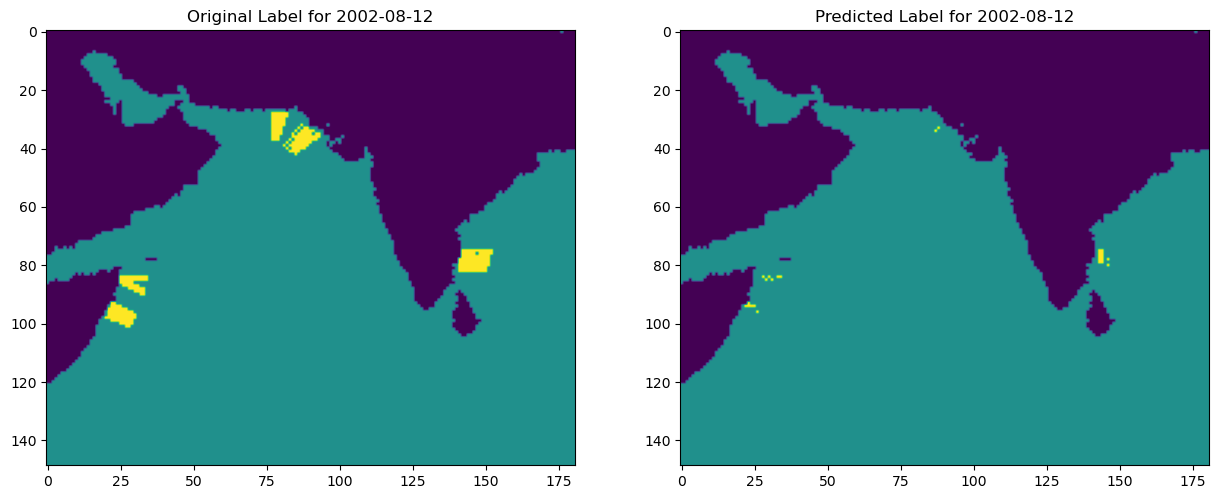

In [60]:
from pandas import Timestamp

selected_date = '2002-08-12'

sample_input = data_map[Timestamp(selected_date + ' 00:00:00')]
sample_label = mask_dataset['upwelling'].sel(time=selected_date).values
sample_input_batch = np.expand_dims(sample_input, axis=0)
predicted_output_batch = model.predict(sample_input_batch)
predicted_output = np.squeeze(predicted_output_batch, axis=0)
predicted_class = np.argmax(predicted_output, axis=-1)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].imshow(sample_label, cmap='viridis')
ax[0].set_title(f'Original Label for {selected_date}')

ax[1].imshow(predicted_class, cmap='viridis')
ax[1].set_title(f'Predicted Label for {selected_date}')

plt.show()

In [14]:
model.save('unet_2000-2020.keras')

In [26]:
def smooth_weights(original_weight, alpha=0.95):
    return alpha * original_weight + (1 - alpha)

labels = [0, 1, 2]
total_samples = y_train.shape[0] * y_train.shape[1] * y_train.shape[2]
weights = {}
smoothed_weights = {}
for label in labels:
    label_count = np.sum(y_train == label)
    weights[label] = total_samples / (len(labels) * label_count)
    smoothed_weights[label] = smooth_weights(weights[label], alpha=0.99)

In [27]:
class_weights_tf = tf.constant([smoothed_weights[label] for label in labels])

def weighted_sparse_categorical_crossentropy(y_true, y_pred):
    weights = tf.gather(class_weights_tf, tf.cast(y_true, tf.int32))
    
    weights = tf.cast(weights, dtype=tf.float32)
    
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    
    return loss * weights

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_unet(input_shape=input_shape)
model.compile(optimizer='adam', loss=weighted_sparse_categorical_crossentropy, metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=75, batch_size=8, callbacks=[early_stopping])

Epoch 1/75
576/576 [==============================] - 255s 442ms/step - loss: 0.4242 - accuracy: 0.8190 - val_loss: 0.3388 - val_accuracy: 0.8842
Epoch 2/75
576/576 [==============================] - 253s 440ms/step - loss: 0.3005 - accuracy: 0.8800 - val_loss: 0.2664 - val_accuracy: 0.8868
Epoch 3/75
576/576 [==============================] - 253s 440ms/step - loss: 0.2722 - accuracy: 0.8942 - val_loss: 0.2760 - val_accuracy: 0.9311
Epoch 4/75
576/576 [==============================] - 253s 440ms/step - loss: 0.2545 - accuracy: 0.9022 - val_loss: 0.2335 - val_accuracy: 0.9275
Epoch 5/75
576/576 [==============================] - 254s 440ms/step - loss: 0.2429 - accuracy: 0.9075 - val_loss: 0.2319 - val_accuracy: 0.9108
Epoch 6/75
576/576 [==============================] - 255s 442ms/step - loss: 0.2353 - accuracy: 0.9117 - val_loss: 0.2318 - val_accuracy: 0.9413
Epoch 7/75
576/576 [==============================] - 253s 439ms/step - loss: 0.2303 - accuracy: 0.9141 - val_loss: 0.2138 -

1/1 [==============================] - 0s 82ms/step


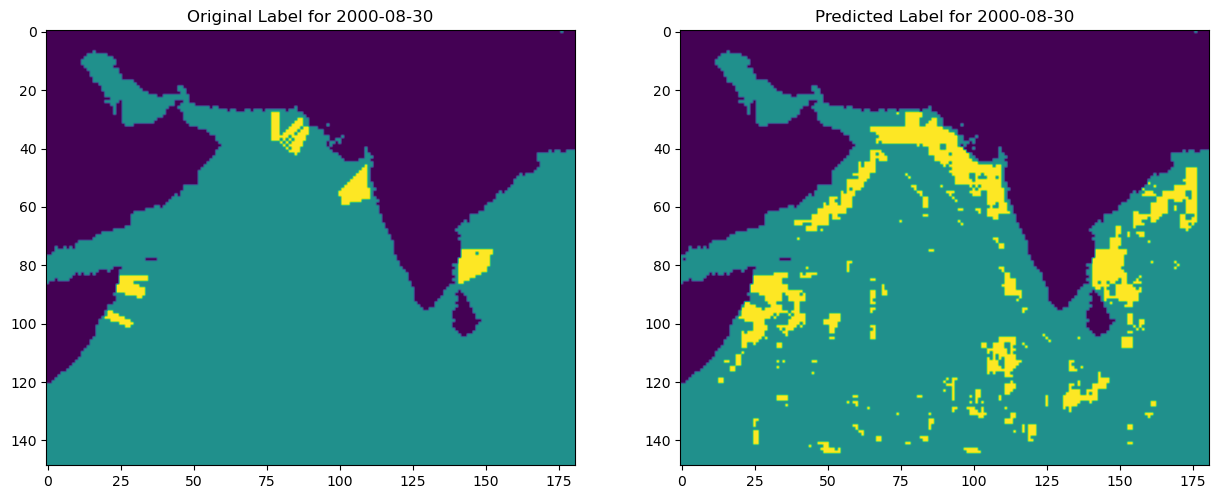

In [25]:
from pandas import Timestamp

selected_date = '2000-08-30'

sample_input = data_map[Timestamp(selected_date + ' 00:00:00')]
sample_label = mask_dataset['upwelling'].sel(time=selected_date).values
sample_input_batch = np.expand_dims(sample_input, axis=0)
predicted_output_batch = model.predict(sample_input_batch)
predicted_output = np.squeeze(predicted_output_batch, axis=0)
predicted_class = np.argmax(predicted_output, axis=-1)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].imshow(sample_label, cmap='viridis')
ax[0].set_title(f'Original Label for {selected_date}')

ax[1].imshow(predicted_class, cmap='viridis')
ax[1].set_title(f'Predicted Label for {selected_date}')

plt.show()